# The realization of a dream: open a Sushi Bar in Bologna

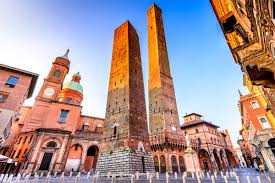

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## Introduction/Business Problem <a name="introduction"></a>

An old aunt left a nice nest egg to the undersigned: 3 million euros. I can finally realize my dream: to open a trendy restaurant in one of the most beautiful Italian cities.
I have always worked in the world of catering and I am doing well in the kitchen. To follow my dreams I went to Japan and spent 5 wonderful years learning the secrets of Sushi. Also I love being among young people. So my dream is to open a Sushi Bar in a university city where there are many young people. The choice falls on Bologna, a city full of young people with a historical university. The opening price may be lower than in other cities. There would be competition in any case because Bologna is full of clubs. There are not as many foreign tourists as in Rome or Milan, so opening in Bologna would have this penalty. But the city is sensitive to news and this is a plus.<br/>
Since I am convinced of my skills and the fact that my Sushi bar can offer something better than the competition, I will try to rent the place where there is a greater concentration of restaurants and possibly Sushi Bars.
Obviously I will try to stay as close as possible to the center, compatibly with the cost of the rent. <br/>
I will try to identify areas with the biggest concentation of young people. <br/>

This study will help anyone who wants to start a restaurant business in a young and dynamic city like Bologna
The business plan that will be illustrated has a general value: anyone who wants to open a restaurant somewhere will find the illustrated methodology and the examples provided useful. The considerations made can be applied to any city and to any type of restaurant / pub / caffee shop etc etc.

## Data <a name="data"></a>

The following data sources will be needed to extract/generate the required information:
* A Pandas dataframe will be provided with some data about the main Bologna's neighborhoods (name, density of inhabitants, distance from the University, cost of rent)
* The dataframe will be enriched by the centers of candidate areas that will be generated algorithmically and approximate addresses of centers of those areas will be obtained using Google Maps API reverse geocoding.
* Number of restaurants and their type and location in every neighborhood will be obtained using Foursquare API. Through a Bubble Chart it will be possible to identify the areas with the highest concentration of restaurants.
* The list of Sushi Bars in the Bologna neighbourhoods and their location with respect to the city center will retrieved using Foursquare API.
* For each Sushi Bar I will analyze the number of clicks received and the comments. From these data I will be able to understand the age of the clientele in relation the position of the restaurant itself.

The area where the Sushi Bar will be opened will be chosen according to the following criteria:
    - density of restaurants
    - density of competitor Sushi bars
    - distance from the University
    - density of young population


# Bologna's neighborhoods

Let's retrieve the Bologna's neighborhoods data. Wea regoing to use the 'pd.read_html'. It returns a list of objects containing the info grabbed from the html page.In this  case the Dataframe we are looking for is contained in the first object of the list.

In [1]:
import pandas as pd
import numpy as np

!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Solving environment: done

# All requested packages already installed.

Libraries imported.


In [2]:
url_html='https://it.wikipedia.org/wiki/Quartieri_di_Bologna'
bologna_obj = pd.read_html(url_html)
bologna_df = bologna_obj[0]
bologna_df.head()

,Quartiere,Superficie (km²),Abitanti[2],Densità (ab/km²),Suddivisioni,Presidente
0,Borgo Panigale-Reno,31436,61.141,194494.00000,"Borgo Panigale, Casteldebole, La Birra, Barca,...",Vincenzo Naldi [3] (Partito Democratico)
1,San Donato-San Vitale,26268,66.297,2.52387,"San Donato, San Vitale, San Donnino, Pilastro,...",Simone Borsari [4] (centrosinistra)
2,Navile,25875,69.187,2.67389,"Lame, Corticella, Bolognina",Daniele Ara [4](centrosinistra)
3,Porto-Saragozza,15766,69.477,4.40676,"Andrea Costa-Saragozza, Malpighi, Marconi, Saf...",Lorenzo Cipriani (centrosinistra)
4,Santo Stefano,30040,64.258,2.13908,"Galvani, Irnerio, Murri, Colli, Roncrio, Barbi...",Rosa Maria Amorevole [5] (centrosinistra)


Some tuning is required on the dataframe. Let's start dropping unuseful columns.

In [3]:
bologna_df = bologna_df.drop(['Presidente'], axis=1)

Now let's rename the column's name from italian to english

In [4]:
print(bologna_df.columns)
bologna_df.columns = ['neighborhood', 'area', 'inhabitants', 'density', 'sub district']
bologna_df.head()

Index(['Quartiere', 'Superficie (km²)', 'Abitanti[2]', 'Densità (ab/km²)',
       'Suddivisioni'],
      dtype='object')


,neighborhood,area,inhabitants,density,sub district
0,Borgo Panigale-Reno,31436,61.141,194494.00000,"Borgo Panigale, Casteldebole, La Birra, Barca,..."
1,San Donato-San Vitale,26268,66.297,2.52387,"San Donato, San Vitale, San Donnino, Pilastro,..."
2,Navile,25875,69.187,2.67389,"Lame, Corticella, Bolognina"
3,Porto-Saragozza,15766,69.477,4.40676,"Andrea Costa-Saragozza, Malpighi, Marconi, Saf..."
4,Santo Stefano,30040,64.258,2.13908,"Galvani, Irnerio, Murri, Colli, Roncrio, Barbi..."


Some more format changes on the numerical data ...

In [54]:
bologna_df['area'] = bologna_df['area']/1000
bologna_df['inhabitants'] = bologna_df['inhabitants'] * 1000
bologna_df['density'] = bologna_df['inhabitants']/bologna_df['area']
bologna_df.head(10)

,neighborhood,area,inhabitants,density,sub district
0,Borgo Panigale-Reno,31.436,61141.0,1944.935742,"Borgo Panigale, Casteldebole, La Birra, Barca,..."
1,San Donato-San Vitale,26.268,66297.0,2523.869347,"San Donato, San Vitale, San Donnino, Pilastro,..."
2,Navile,25.875,69187.0,2673.893720,"Lame, Corticella, Bolognina"
3,Porto-Saragozza,15.766,69477.0,4406.761385,"Andrea Costa-Saragozza, Malpighi, Marconi, Saf..."
4,Santo Stefano,30.040,64258.0,2139.081225,"Galvani, Irnerio, Murri, Colli, Roncrio, Barbi..."
5,Savena,11.469,59810.0,5214.927195,"Mazzini, San Ruffillo, Fossolo, Pontevecchio, ..."


In [55]:
bologna_df.describe()

,area,inhabitants,density
count,6.000000,6.000000,6.000000
mean,23.475667,65028.333333,3150.578102
std,8.045002,4040.555292,1336.878821
min,11.469000,59810.000000,1944.935742
25%,18.293250,61920.250000,2235.278255
50%,26.071500,65277.500000,2598.881533
75%,29.097000,68464.500000,3973.544469
max,31.436000,69477.000000,5214.927195


Let's try to have a graphical representation of the density.

In [42]:
%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt

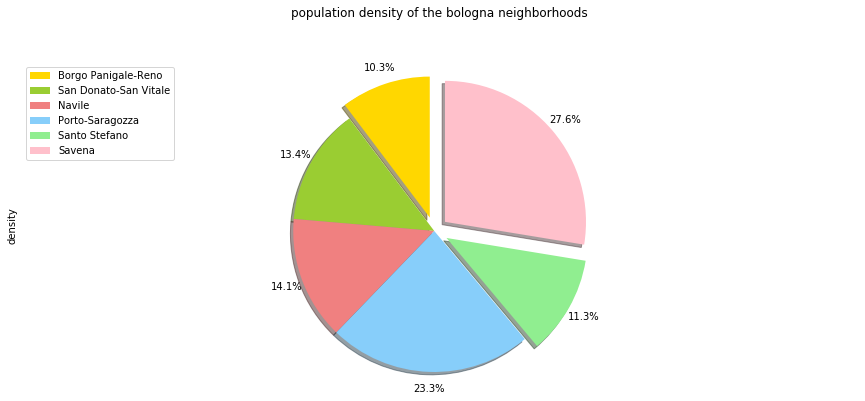

In [47]:
colors_list = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue', 'lightgreen', 'pink']
explode_list = [0.1, 0, 0, 0, 0.1, 0.1] # ratio for each continent with which to offset each wedge.
bologna_df['density'].plot(kind='pie',
                            figsize=(15, 6),
                            autopct='%1.1f%%', 
                            startangle=90,    
                            shadow=True,       
                            labels=None,         # turn off labels on pie chart
                            pctdistance=1.12,    # the ratio between the center of each pie slice and the start of the text generated by autopct 
                            colors=colors_list,  # add custom colors
                            explode=explode_list # 'explode' lowest 3 continents
                            )

# scale the title up by 12% to match pctdistance
plt.title('population density of the bologna neighborhoods', y=1.12) 

plt.axis('equal') 

# add legend
plt.legend(labels=bologna_df['neighborhood'], loc='upper left') 

plt.show()

From this first analysis we realize that there are a couple of neighborhoods more crowded than the other. They are 'Savena' and 'Porto Saragozza'. So we can guess that those neighboorhood are in the downtown. We have to keep in mind this information in the future.<br/>
Let's try to retrieve the latitude and longitude of every neighborhood. This data will be added to the current dataframe.

In [75]:
geolocator = Nominatim(user_agent="bo_explorer")
longitude = []
latitude = []
for neigh in bologna_df['neighborhood']:
    address = neigh + ', Bologna, Italy'
    location = geolocator.geocode(address)
    latitude.append(location.latitude)
    longitude.append(location.longitude)
    #print('The geograpical coordinate of {} are {}, {}.'.format(neigh, location.latitude, location.longitude))
#print(latitude)
#print(longitude)
bologna_df['latitude'] = latitude
bologna_df['longitude'] = longitude
bologna_df.head()

,neighborhood,area,inhabitants,density,sub district,latitude,longitude
0,Borgo Panigale-Reno,31.436,61141.0,1944.935742,"Borgo Panigale, Casteldebole, La Birra, Barca,...",44.521942,11.271077
1,San Donato-San Vitale,26.268,66297.0,2523.869347,"San Donato, San Vitale, San Donnino, Pilastro,...",44.511899,11.395177
2,Navile,25.875,69187.0,2673.893720,"Lame, Corticella, Bolognina",44.518470,11.328901
3,Porto-Saragozza,15.766,69477.0,4406.761385,"Andrea Costa-Saragozza, Malpighi, Marconi, Saf...",44.477876,11.304899
4,Santo Stefano,30.040,64258.0,2139.081225,"Galvani, Irnerio, Murri, Colli, Roncrio, Barbi...",44.492055,11.349035


Save the dataframe as a csv file.

In [76]:
bologna_df.to_csv(r'bologna-neigh.csv', index=False)

Here we go. The Pandas Dataframe has been cleaned and now we can move further and add some more interesting informations to it.

## Define Foursquare Credentials and Version

In [63]:
CLIENT_ID = 'WWBTWNSZFP50UEEBGV00MGOCHXEY1ORQWQLRNO0KLYZURLQI' # your Foursquare ID
CLIENT_SECRET = 'NFQAIQUXJ0UYTEMS3USDDMQRCFJITUFG3N2KBPC43D3UTHBL' # your Foursquare Secret
VERSION = '20180604'
LIMIT = 30
print('My credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

My credentails:
CLIENT_ID: WWBTWNSZFP50UEEBGV00MGOCHXEY1ORQWQLRNO0KLYZURLQI
CLIENT_SECRET:NFQAIQUXJ0UYTEMS3USDDMQRCFJITUFG3N2KBPC43D3UTHBL


Create a map of Bologna with neighborhoods superimposed on top

In [79]:
bologna_address = 'Bologna, Italy'
location = geolocator.geocode(bologna_address)
bo_latitude = location.latitude
bo_longitude = location.longitude
print('The geograpical coordinate of Bologna are {}, {}.'.format(bo_latitude, bo_longitude))

The geograpical coordinate of Bologna are 44.4936714, 11.3430347.


In [84]:
university_address = 'Via Zamboni 33, Bologna, Italy'
location = geolocator.geocode(university_address)
university_latitude = location.latitude
university_longitude = location.longitude
print('The geograpical coordinate of Bologna University are {}, {}.'.format(university_latitude, university_longitude))

The geograpical coordinate of Bologna University are 44.4971104, 11.352995.


In [85]:
# create map of New York using latitude and longitude values
map_bologna = folium.Map(location=[bo_latitude, bo_longitude], zoom_start=10)

# add markers to map
for lat, lng, neighborhood in zip(bologna_df['latitude'], bologna_df['longitude'], bologna_df['neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_bologna)  
    
map_bologna